In [126]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import sys
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [127]:
meta = pd.read_csv("1.tsv", sep = '\t', header = None, encoding='ISO-8859-1')
meta.head()

,0,1,2
0,1,12 Rounds 3: Lockdown,"{""1"":""action"",""2"":""crime"",""4"":""thriller""}"
1,2,13 hours: The Secret Soldiers of Benghazi,"{""1"":""action"",""5"":""family"",""6"":""fantasy""}"
2,3,90 Minutes in Heaven,"{""3"":""drama""}"
3,4,Aloha,"{""7"":""comedy"",""3"":""drama"",""8"":""romance""}"
4,5,American Justice,"{""1"":""action""}"


In [128]:
# rename columns
meta.columns = ["movie_id","movie_name","genre"]

In [129]:
subtitles = []

csv.field_size_limit(1000000)
with open("2.tsv", encoding='ISO-8859-1') as f:
       reader = csv.reader(f, dialect='excel-tab') 
       for row in tqdm(reader):
            subtitles.append(row)

284it [00:00, 393.67it/s]


In [130]:
movie_id = []
subtitle = []

# extract movie Ids and subtitle
for i in tqdm(subtitles):
  movie_id.append(i[0])
  subtitle.append(i[1])

# create dataframe
movies = pd.DataFrame({'movie_id': movie_id, 'subtitle': subtitle})

100%|██████████| 284/284 [00:00<?, ?it/s]


In [131]:
movies.head(5)

,movie_id,subtitle
0,1,"1 00:02:32,930 --> 00:02:34,947 Nice place you got here. 2 00:02:35,432 --> 00:02:36,899 Burke? 3 00:02:36,999 --> 00:02:38,248 Relax. 4 00:02:39,751 --> 00:02:41,371 I'm going to level with you. 5 00:02:41,769 --> 00:02:43,889 Hell of a day I've had. 6 00:02:45,639 --> 00:02:47,378 Thirsty..."
1,2,"1 00:01:28,322 --> 00:01:31,006 <i>This marks the end</i> 2 00:01:31,007 --> 00:01:33,691 <i>of a long and painful chapter for the people of Libya,</i> 3 00:01:33,694 --> 00:01:37,096 <i>who now have the opportunity to determine their own destiny</i> 4 00:01:37,098 --> 00:01:39,331 <i>in a ne..."
2,3,"1 00:03:56,720 --> 00:04:02,011 I died on January 18, 1989. 2 00:04:03,760 --> 00:04:06,300 I was the father of three children. 3 00:04:06,400 --> 00:04:09,165 The husband of a wonderful wife. 4 00:04:10,600 --> 00:04:12,170 A man with a great future. 5 00:04:13,320 --> 00:04:15,322 I was 38..."
3,4,"1 00:02:01,720 --> 00:02:06,009 There was a time I knew everything in the sky. 2 00:02:06,600 --> 00:02:08,329 Every satellite... 3 00:02:08,560 --> 00:02:10,688 every constellation... 4 00:02:10,880 --> 00:02:13,690 souvenirs of space walks and astronauts... 5 00:02:13,880 --> 00:02:17,009 ..."
4,5,"1 00:00:20,293 --> 00:00:23,263 This is LA 1-6 in pursuit of a robbery suspect. 2 00:00:23,296 --> 00:00:25,463 East of Crenshaw and Slauson Boulevard. 3 00:00:29,803 --> 00:00:31,238 Whoo! 4 00:00:31,271 --> 00:00:33,574 This cop can kiss my ass! 5 00:00:42,849 --> 00:00:44,809 Jack, I thin..."


In [132]:
# change datatype of 'movie_id'
meta['movie_id'] = meta['movie_id'].astype(str)

# merge meta with movies
movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

movies.head()

,movie_id,subtitle,movie_name,genre
0,1,"1 00:02:32,930 --> 00:02:34,947 Nice place you got here. 2 00:02:35,432 --> 00:02:36,899 Burke? 3 00:02:36,999 --> 00:02:38,248 Relax. 4 00:02:39,751 --> 00:02:41,371 I'm going to level with you. 5 00:02:41,769 --> 00:02:43,889 Hell of a day I've had. 6 00:02:45,639 --> 00:02:47,378 Thirsty...",12 Rounds 3: Lockdown,"{""1"":""action"",""2"":""crime"",""4"":""thriller""}"
1,2,"1 00:01:28,322 --> 00:01:31,006 <i>This marks the end</i> 2 00:01:31,007 --> 00:01:33,691 <i>of a long and painful chapter for the people of Libya,</i> 3 00:01:33,694 --> 00:01:37,096 <i>who now have the opportunity to determine their own destiny</i> 4 00:01:37,098 --> 00:01:39,331 <i>in a ne...",13 hours: The Secret Soldiers of Benghazi,"{""1"":""action"",""5"":""family"",""6"":""fantasy""}"
2,3,"1 00:03:56,720 --> 00:04:02,011 I died on January 18, 1989. 2 00:04:03,760 --> 00:04:06,300 I was the father of three children. 3 00:04:06,400 --> 00:04:09,165 The husband of a wonderful wife. 4 00:04:10,600 --> 00:04:12,170 A man with a great future. 5 00:04:13,320 --> 00:04:15,322 I was 38...",90 Minutes in Heaven,"{""3"":""drama""}"
3,4,"1 00:02:01,720 --> 00:02:06,009 There was a time I knew everything in the sky. 2 00:02:06,600 --> 00:02:08,329 Every satellite... 3 00:02:08,560 --> 00:02:10,688 every constellation... 4 00:02:10,880 --> 00:02:13,690 souvenirs of space walks and astronauts... 5 00:02:13,880 --> 00:02:17,009 ...",Aloha,"{""7"":""comedy"",""3"":""drama"",""8"":""romance""}"
4,5,"1 00:00:20,293 --> 00:00:23,263 This is LA 1-6 in pursuit of a robbery suspect. 2 00:00:23,296 --> 00:00:25,463 East of Crenshaw and Slauson Boulevard. 3 00:00:29,803 --> 00:00:31,238 Whoo! 4 00:00:31,271 --> 00:00:33,574 This cop can kiss my ass! 5 00:00:42,849 --> 00:00:44,809 Jack, I thin...",American Justice,"{""1"":""action""}"


In [133]:
movies['genre'][0]

'{"1":"action","2":"crime","4":"thriller"}'

In [134]:
type(json.loads(movies['genre'][0]))

dict

In [135]:
# an empty list
genres = [] 

# extract genres
for i in movies['genre']: 
  genres.append(list(json.loads(i).values())) 

# add to 'movies' dataframe  
movies['genre_new'] = genres

In [136]:
# remove samples with 0 genre tags
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

In [137]:
movies_new.shape, movies.shape

((284, 5), (284, 5))

In [138]:
movies.head(201)

,movie_id,subtitle,movie_name,genre,genre_new
0,1,"1 00:02:32,930 --> 00:02:34,947 Nice place you got here. 2 00:02:35,432 --> 00:02:36,899 Burke? 3 00:02:36,999 --> 00:02:38,248 Relax. 4 00:02:39,751 --> 00:02:41,371 I'm going to level with you. 5 00:02:41,769 --> 00:02:43,889 Hell of a day I've had. 6 00:02:45,639 --> 00:02:47,378 Thirsty...",12 Rounds 3: Lockdown,"{""1"":""action"",""2"":""crime"",""4"":""thriller""}","[action, crime, thriller]"
1,2,"1 00:01:28,322 --> 00:01:31,006 <i>This marks the end</i> 2 00:01:31,007 --> 00:01:33,691 <i>of a long and painful chapter for the people of Libya,</i> 3 00:01:33,694 --> 00:01:37,096 <i>who now have the opportunity to determine their own destiny</i> 4 00:01:37,098 --> 00:01:39,331 <i>in a ne...",13 hours: The Secret Soldiers of Benghazi,"{""1"":""action"",""5"":""family"",""6"":""fantasy""}","[action, family, fantasy]"
2,3,"1 00:03:56,720 --> 00:04:02,011 I died on January 18, 1989. 2 00:04:03,760 --> 00:04:06,300 I was the father of three children. 3 00:04:06,400 --> 00:04:09,165 The husband of a wonderful wife. 4 00:04:10,600 --> 00:04:12,170 A man with a great future. 5 00:04:13,320 --> 00:04:15,322 I was 38...",90 Minutes in Heaven,"{""3"":""drama""}",[drama]
3,4,"1 00:02:01,720 --> 00:02:06,009 There was a time I knew everything in the sky. 2 00:02:06,600 --> 00:02:08,329 Every satellite... 3 00:02:08,560 --> 00:02:10,688 every constellation... 4 00:02:10,880 --> 00:02:13,690 souvenirs of space walks and astronauts... 5 00:02:13,880 --> 00:02:17,009 ...",Aloha,"{""7"":""comedy"",""3"":""drama"",""8"":""romance""}","[comedy, drama, romance]"
4,5,"1 00:00:20,293 --> 00:00:23,263 This is LA 1-6 in pursuit of a robbery suspect. 2 00:00:23,296 --> 00:00:25,463 East of Crenshaw and Slauson Boulevard. 3 00:00:29,803 --> 00:00:31,238 Whoo! 4 00:00:31,271 --> 00:00:33,574 This cop can kiss my ass! 5 00:00:42,849 --> 00:00:44,809 Jack, I thin...",American Justice,"{""1"":""action""}",[action]
...,...,...,...,...,...
196,197,"1 00:00:11,365 --> 00:00:13,278 âªâª 2 00:00:23,930 --> 00:00:25,799 âªâª 3 00:00:28,539 --> 00:00:30,452 âªâª 4 00:00:49,104 --> 00:00:50,973 âªâª 5 00:01:00,060 --> 00:01:01,930 âªâª 6 00:01:12,191 --> 00:01:14,060 âªâª 7 00:02:08,017 --> 00:02:09,799 Harper?! 8 00:02:16,583...",Haunt,"{""11"":""horror"",""4"":""thriller""}","[horror, thriller]"
197,198,"1 00:00:33,283 --> 00:00:35,616 <i>The year is 517 AD,</i> 2 00:00:35,661 --> 00:00:37,323 <i>known as the Dark Ages,</i> 3 00:00:37,371 --> 00:00:39,579 <i>and for fucking good reason.</i> 4 00:00:40,541 --> 00:00:43,705 <i>An endless war between the armies of man and the creatures of darkne...",Hellboy,"{""1"":""action"",""10"":""adventure""}","[action, adventure]"
198,199,"1 00:00:31,560 --> 00:00:32,617 Quiet! 2 00:00:41,761 --> 00:00:43,367 What are you? 3 00:00:43,641 --> 00:00:45,023 Shhh. 4 00:00:45,813 --> 00:00:46,805 Oh. 5 00:00:58,576 --> 00:00:59,545 Oh! 6 00:01:01,700 --> 00:01:02,833 Aah! You're a demon! 7 00:01:03,005 --> 00:01:04,224 Shh-shh-sh...",how to Train Your Dragon: The Hidden World,"{""1"":""action"",""10"":""adventure""}","[action, adventure]"
199,200,"1 00:01:01,130 --> 00:01:03,670 It's like we were doomed to destroy our planet. 2 00:01:04,963 --> 00:01:07,553 Some say it was because of the increasing pollution. 3 00:01:09,296 --> 00:01:10,876 I just call it human nature. 4 00:01:13,005 --> 00:01:15,585 A few scientists predicted what wou...",IO,"{""3"":""drama"",""10"":""adventure""}","[drama, adventure]"


In [139]:
# get all genre tags in a list
all_genres = sum(genres,[])
len(set(all_genres))

13

In [140]:

all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

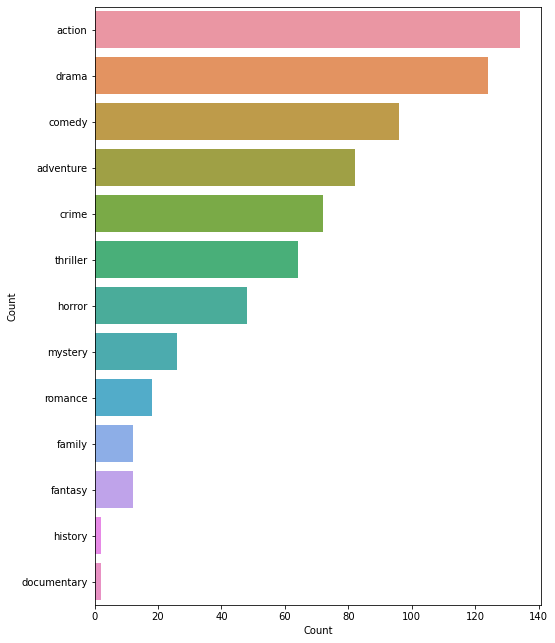

In [141]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(8,11)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [142]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [143]:
movies_new['clean_subtitle'] = movies_new['subtitle'].apply(lambda x: clean_text(x))

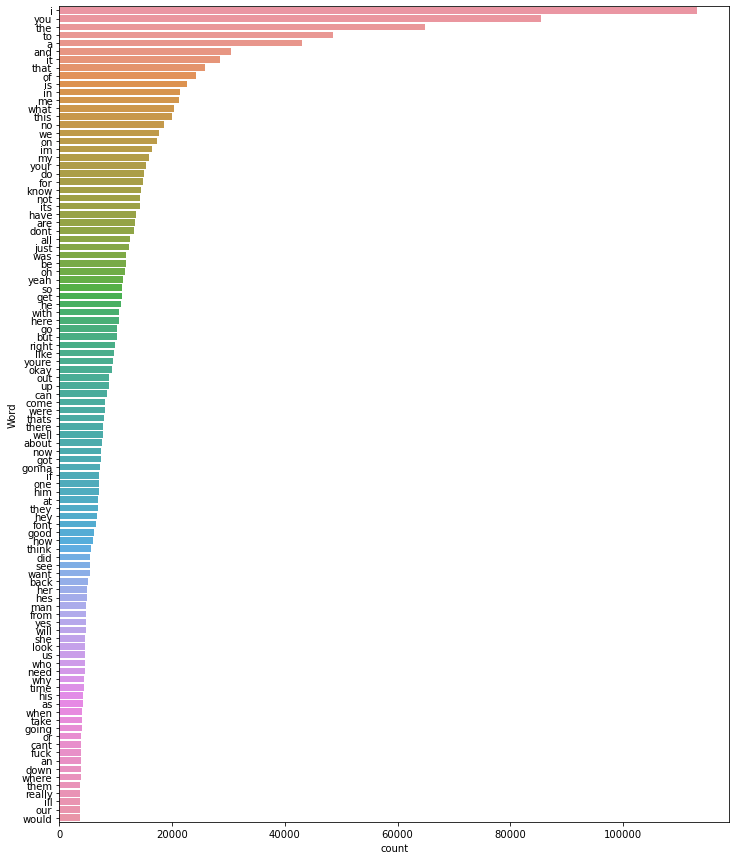

In [144]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(movies_new['clean_subtitle'], 100)

In [145]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [146]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies_new['clean_subtitle'] = movies_new['clean_subtitle'].apply(lambda x: remove_stopwords(x))

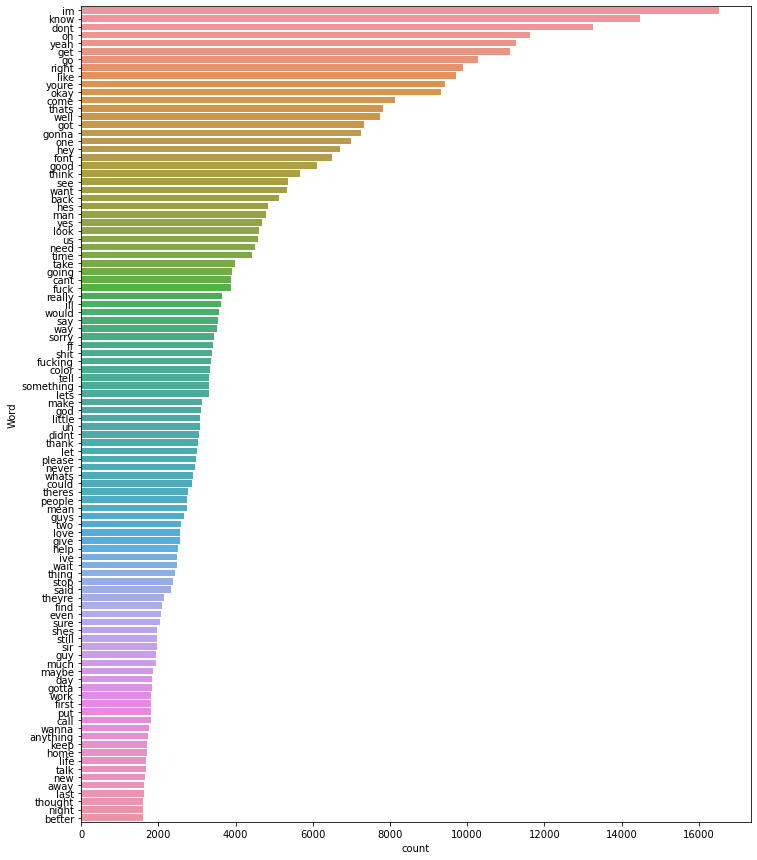

In [147]:
freq_words(movies_new['clean_subtitle'], 100)

In [148]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(movies_new['genre_new'])

In [149]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,  max_features=10000)

In [150]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_subtitle'], y, test_size=0.2, random_state=9)

In [151]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [152]:
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

# Apply Algorithm

In [153]:
from sklearn import svm

lr = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

y_pred[3]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0])

In [154]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('drama', 'romance')

In [156]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.9166666666666667

In [157]:
from sklearn.metrics import classification_report


print("The classification report for Multinomial Naive Bayes Classifier is as followed:\n\n",
      classification_report(yval, y_pred))

The classification report for Multinomial Naive Bayes Classifier is as followed:

               precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      1.00      1.00        12
           2       1.00      0.88      0.94        17
           3       1.00      0.63      0.77        19
           4       0.00      0.00      0.00         1
           5       1.00      0.83      0.90        23
           6       1.00      0.50      0.67         2
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.89      1.00      0.94         8
          10       1.00      0.83      0.91         6
          11       1.00      1.00      1.00         1
          12       1.00      0.89      0.94        18

   micro avg       0.98      0.86      0.92       141
   macro avg       0.76      0.66      0.70       141
weighted avg       0.97      0.86      0.90       1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score
import itertools
class_names=["action","drama","comedy","adventure","crime","thriller","horror","mystery","romance","family","fantasy","history","documentary"]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[32  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0]
 [ 2  0  6  0  0  0  0]
 [ 1  0  0  3  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  5]]


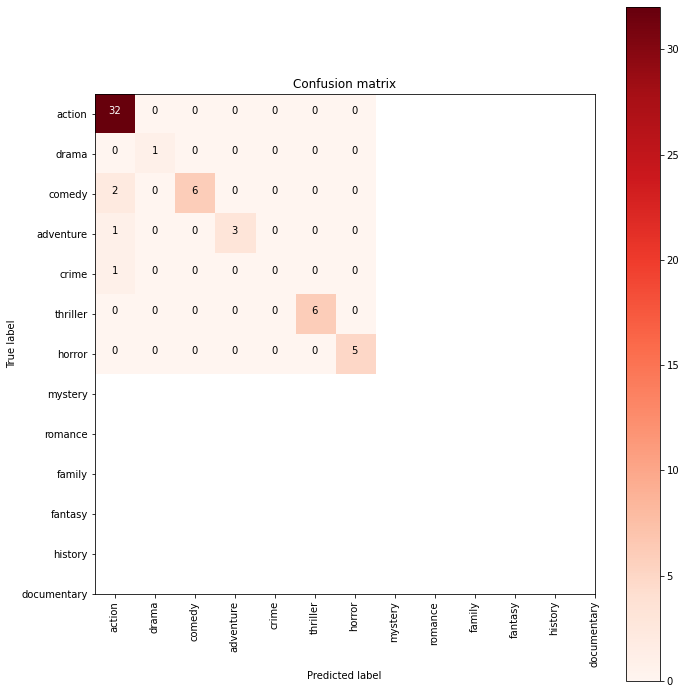

In [33]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix(yval.argmax(axis=1), y_pred.argmax(axis=1)),classes=class_names)

plt.show()

In [31]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [32]:
for i in range(5): 
  k = xval.sample(1).index[0]
  print("Movie: ", movies_new['movie_name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",movies_new['genre_new'][k], "\n")


Movie:  Frozen 
Predicted genre:  [('adventure', 'comedy')]
Actual genre:  ['comedy', 'adventure'] 

Movie:  Battlestar Galactica 
Predicted genre:  [('action', 'adventure')]
Actual genre:  ['action', 'adventure'] 

Movie:  Charlie's Angels 
Predicted genre:  [('action', 'adventure', 'comedy')]
Actual genre:  ['action', 'adventure', 'comedy'] 

Movie:  1917 
Predicted genre:  [('drama', 'thriller')]
Actual genre:  ['thriller', 'drama'] 

Movie:  Shazam 
Predicted genre:  [('action', 'adventure', 'comedy')]
Actual genre:  ['action', 'adventure', 'comedy'] 

